# **Home Credit Default Risk**  
This project attempts to model and predict the default risk of consumer loan applicants by analyzing and extracting data from several sources including bureau data as well as previous home credit applications and installments. I divided the work into the following steps / sections:

## 1. Exploratory Data Analysis 
#### 1a. Baseline Models
\- Run logistic regression / random forest baseline models to gauge expectations and get an initial impression on main application file and the target variable  
#### 1b. Clean Data  
\- Investigate and impute null values as well as anomalies across main application file and supplemental files
#### 1c. Feature Exploration
\- Explore features by analyzing correlations and relationship with target variable (default / no default)  
## 2. Feature Engineering
#### 2a. Supplemental Data 
\- Engineer features by grouping and flattening supplemental datasets
#### 2b. Application Data
\- Merge supplemental data with main application dataframe. Create additional features through a combination of manual calculations with domain knowledge as well as polynomial features 
## 3. Gradient Boosting Classifier
#### ***3a. Train LightGBM***  
\- ***Train LightGBM model using data and previously engineered features***  
#### 3b. Model Results / Analysis  
\- Compare models and assess feature importances
  

<hr>

## __3a. Gradient Boosting Classifier__
#### __Sections__
3a1. Load in all merged data and prepare for modeling  
3a2. Tune LightGBM model  
3b3. Train LightGBM model  
3b4. Notes on model version / save

<hr>

In [56]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMClassifier

from rq_config import project_3_path

import os
import warnings
import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib  inline

In [2]:
# Establish model / data directories

model_version = '1'
model_dir = os.path.join(project_3_path,'models/',f'lightgbm{model_version}/')
pkl_dir = os.path.join(project_3_path,'data/','pkl/')

### __3a1. Load in all merged data and prepare for modeling__  

In [3]:
data = pd.read_pickle(pkl_dir + 'merged.pkl')

In [4]:
# Impute all null values

data = data.fillna(-99999)

In [5]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY_ANOMALY,DAYS_EMPLOYED_ANOMALY,OWN_CAR_AGE_ANOMALY,CNT_FAM_MEMBERS_ANOMALY,OBS_30_CNT_SOCIAL_CIRCLE_ANOMALY,OBS_60_CNT_SOCIAL_CIRCLE_ANOMALY,AMT_REQ_CREDIT_BUREAU_QRT_ANOMALY,CREDIT_ANNUITY_RATIO,CREDIT_INCOME_RATIO,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZ

In [6]:
data.shape

(307511, 996)

### __3a2. Tune LightGBM Model__

In [7]:
model = LGBMClassifier(
    n_estimators = 2000,
    learning_rate = 0.05,
    num_leaves = 26,
    metric = 'auc',
    colsample_bytree = 0.3,
    subsample = 0.9320,
    max_depth = 4,
    reg_alpha = 4.8299,
    reg_lambda = 3.6,
    min_split_gain = 0.0068,
    min_child_weight = 9.8138,
    silent = False,
    verbose = 1,
    n_jobs = 16, # Parallelize model
    random_state = 619,
    scale_pos_weight = 5 # Handle imbalance by scaling positive class
    )

### __3a3. Train Model__

In [13]:
# Load all categorical features for lgbm model

categorical_features = pickle.load(open(pkl_dir + 'categorical_features.pkl','rb'))

In [14]:
# Train / test split data and analyze result using generated test set since this isn't being submitted to Kaggle.

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
time_0 = time.time()

excluded_features = ['SK_ID_CURR','TARGET']

y = data_train['TARGET']

# Run 5 fold model
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=90210)
oof_preds = np.zeros(data_train.shape[0])
feature_importance_df = pd.DataFrame()

# Fold scores
scores = []

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data_train,data_train['TARGET'])):
    
    # Train / val split on training data subset
    trn, val = data_train.iloc[trn_idx], data_train.iloc[val_idx]
    
    features = [f_ for f_ in trn.columns if f_ not in excluded_features]
        
    trn_x, trn_y = trn[features], trn['TARGET']
    val_x, val_y = val[features], val['TARGET']
    
    # Fit model
    model.fit(trn_x, trn_y, 
            eval_set= [(val_x, val_y)], 
            eval_metric='auc', verbose=200, early_stopping_rounds=100,
            categorical_feature = categorical_features,
           )
    
    oof_preds[val_idx] = model.predict_proba(val_x)[:,1]
    
    fold_score = roc_auc_score(val_y, oof_preds[val_idx])
    scores.append(fold_score)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, fold_score))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = features
    fold_importance_df['importance_gain'] = model.booster_.feature_importance(importance_type='gain')
    fold_importance_df['importance_split'] = model.booster_.feature_importance(importance_type='split')
    fold_importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
train_score = roc_auc_score(y,oof_preds)

print('Full AUC score %.6f +- %0.4f' % (train_score, np.std(scores)))

end = time.time()
print('training time:', str((end - time_0)), 'seconds')

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.773177
[400]	valid_0's auc: 0.776852
[600]	valid_0's auc: 0.778523
[800]	valid_0's auc: 0.778955
Early stopping, best iteration is:
[769]	valid_0's auc: 0.779139
Fold  1 AUC : 0.779139
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.788739
[400]	valid_0's auc: 0.793101
[600]	valid_0's auc: 0.794012
Early stopping, best iteration is:
[695]	valid_0's auc: 0.794294
Fold  2 AUC : 0.794294
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.780761
[400]	valid_0's auc: 0.785469
[600]	valid_0's auc: 0.787298
[800]	valid_0's auc: 0.787949
[1000]	valid_0's auc: 0.788165
Early stopping, best iteration is:
[1018]	valid_0's auc: 0.788211
Fold  3 AUC : 0.788211
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.771241
[400]	valid_0's auc: 0.776358
[600]	valid_0's auc: 0.777785
[800]	valid_0's auc: 0.778297
[1

In [69]:
y = data_train['TARGET']

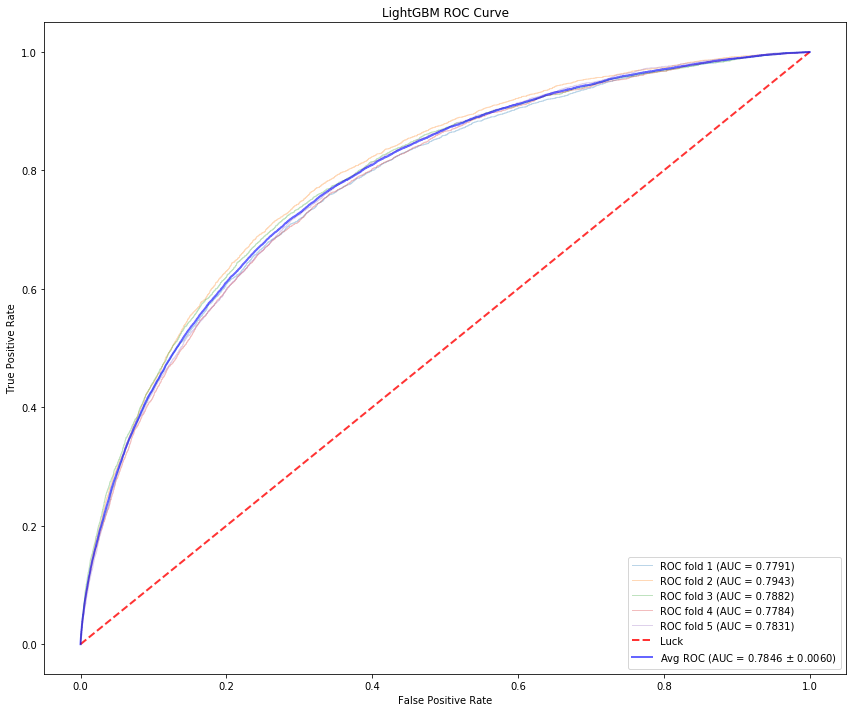

In [73]:
# Plot ROC curves
plt.figure(figsize=(12,10))
scores = [] 

# Plot ROC Curves from each fold
for n_fold, (_, val_idx) in enumerate(folds.split(data_train, data_train['TARGET'])):  
    # Plot the roc curve
    fpr, tpr, thresholds = roc_curve(y.iloc[val_idx], oof_preds[val_idx])
    score = roc_auc_score(y.iloc[val_idx], oof_preds[val_idx])
    scores.append(score)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
# Plot AVG ROC
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
fpr, tpr, thresholds = roc_curve(y, oof_preds)
score = roc_auc_score(y, oof_preds)
plt.plot(fpr, tpr, color='b',
         label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
         lw=2, alpha=.6)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()

### __3a4. Save model / data__

In [16]:
pickle.dump(folds,open(model_dir + 'folds.pkl','wb'))
pickle.dump(model,open(model_dir + 'model.pkl','wb'))
pickle.dump(data_train,open(model_dir + 'data_train.pkl','wb'))
pickle.dump(data_test,open(model_dir + 'data_test.pkl','wb'))

feature_importance_df.to_pickle(model_dir + 'feature_importance.pkl')